# Part 2. Deep Learning Frameworks

Before we go into deep learning modelling, we will first need to have a quick familiarisation with a deep learning framework. We recommend __[Keras](https://keras.io)__, which is built on top of Tensorflow, but alternatively, you can consider __[PyTorch](https://pytorch.org)__. Resources are abundant online on how to use them, but here are some official guides to get you started:
- PyTorch has a [60 Minute Blitz Guide](https://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html)
- Tensorflow has an [Intro to Keras guide](https://www.tensorflow.org/guide/keras)

A few words on the difference between Keras and PyTorch - Keras is a high level wrapper on top of Google's Tensorflow, the most popular deep learning framework out there. Being more low level, Tensorflow faces many issues and troubles, which are addressed by the abstractions of Keras, making it a great way to start. Facebook's PyTorch on the other hand is a newcomer which has received massive interest in recent years, and is playing catch up to Tensorflow/Keras.

If you are more interested in how deep learning software has evolved since the days of Caffe and Theano as well as more in depth into what is happening in the software behind the scenes, we also recommend a [full lecture from Stanford](https://www.youtube.com/watch?v=6SlgtELqOWc) on this topic, although this is extra knowledge that isn't fully critical to this week.

Base on the tutorials you go through, you should be ready to build a 2 (or more) layer Multi-Level Perceptron (MLP) with deep learning. With the dataset you have prepared your machine learning model in the previous section, run your data through a MLP model with `Dense` (`Linear`) layers instead. Do some slight model adjustments, and discuss what kind of adjustments lead to improvements in score.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
from pathlib import Path
import tarfile
import pickle
import requests
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping
from keras.optimizers import SGD
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical

print(tf.VERSION)
print(tf.keras.__version__)

C:\Users\Raymond\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


1.12.0
2.1.6-tf


Using TensorFlow backend.


## 1. Data transformations/preprocessing

Most neural networks expect the images of a fixed size. Therefore, you will need to write some prepocessing code. At the basic level, you will need to normalise the data. Use the appropriate data generator/loader methods to encapsulate your data for training purposes. Do the same for both the train and test (and val, if exist) sets.

In [2]:
data_folder = Path("data/raw/")
file_to_open = data_folder / "cifar-10-python.tar.gz"

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def getRawDictionary(fileName):
    batch = data_folder / "cifar-10-batches-py" / fileName
    data = unpickle(batch)
    return data

train_imgs = []
train_labels = []
test_imgs = []
test_labels = []

for i in range(1,6):
    data_batch = getRawDictionary("data_batch_" + str(i))
    if i == 1:
        train_imgs = data_batch[b'data']
        train_labels = np.asarray(data_batch[b'labels'])
    else:
        train_imgs = np.concatenate((train_imgs, data_batch[b'data']), axis=0)
        train_labels = np.concatenate((train_labels, np.asarray(data_batch[b'labels'])), axis=0)
#         train_imgs = numpy.append(train_imgs, data_batch[b'data'], axis=0)
#         train_labels = numpy.append(train_labels, np.asarray(data_batch[b'labels']), axis=0)
    
test_batch = getRawDictionary("test_batch")
test_imgs = test_batch[b'data']
test_labels= np.asarray(test_batch[b'labels'])

label_dict = getRawDictionary("batches.meta")
label_names = label_dict[b'label_names']

In [3]:
print(train_imgs.shape)
print(test_imgs.shape)

(50000, 3072)
(10000, 3072)


In [4]:
train_labels_encoded = to_categorical(train_labels)
test_labels_encoded = to_categorical(test_labels)

In [5]:
train_imgs = train_imgs / 255.0
test_imgs = test_imgs / 255.0

def toGrayScale(imgs):
    R = imgs[:,0:1024]
    G = imgs[:,1024:2048]
    B = imgs[:,2048:]

    imgs_grey = (R + G + B)/3
    return imgs_grey

train_imgs_grey = toGrayScale(train_imgs)
test_imgs_grey = toGrayScale(test_imgs)

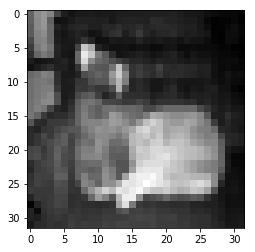

In [6]:
def drawGrayScale(img, img_index):
    plt.imshow(img[17,:].reshape(32,32), cmap='gray')
    plt.show()
    
drawGrayScale(train_imgs_grey, 17)

## 2.  Build multi-layer perceptron neural network models with Keras 

The Keras Python library for deep learning focuses on the creation of models as a sequence of layers.

In here, you will discover the simple components that you can use to create neural networks and simple deep learning models using Keras.

In [7]:
n_cols = train_imgs_grey.shape[1]

model = Sequential()
model.add(Dense(100, activation='relu',input_shape=(n_cols,)))
model.add(Dense(100, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

early_stopping_monitor = EarlyStopping(patience=3)

In [8]:
model.fit(train_imgs_grey, train_labels_encoded, epochs=40, validation_split=0.3, callbacks=[early_stopping_monitor])

Train on 35000 samples, validate on 15000 samples
Epoch 1/40
35000/35000 [==============================] - 9s 243us/step - loss: 2.0415 - acc: 0.2570 - val_loss: 1.9333 - val_acc: 0.3042
Epoch 2/40
35000/35000 [==============================] - 5s 156us/step - loss: 1.8990 - acc: 0.3186 - val_loss: 1.8804 - val_acc: 0.3227
Epoch 3/40
35000/35000 [==============================] - 5s 155us/step - loss: 1.8419 - acc: 0.3413 - val_loss: 1.8486 - val_acc: 0.3411
Epoch 4/40
35000/35000 [==============================] - 5s 152us/step - loss: 1.8029 - acc: 0.3566 - val_loss: 1.8182 - val_acc: 0.3467
Epoch 5/40
35000/35000 [==============================] - 5s 152us/step - loss: 1.7711 - acc: 0.3685 - val_loss: 1.7815 - val_acc: 0.3655
Epoch 6/40
35000/35000 [==============================] - 5s 152us/step - loss: 1.7457 - acc: 0.3762 - val_loss: 1.8033 - val_acc: 0.3579
Epoch 7/40
35000/35000 [==============================] - 5s 155us/step - loss: 1.7249 - acc: 0.3848 - val_loss: 1.7741 - 

In [9]:
model.evaluate(test_imgs_grey, test_labels_encoded, batch_size=32)

10000/10000 [==============================] - 0s 42us/step


[1.7128542533874511, 0.4002]

## 3. Train the MLP network in CIFAR-10

The main objective is to train the MLP network to achieve a balance between the ability to respond correctly to the input patterns that are used for training and the ability to provide good response to the input that is similar. Use the stochastic gradient descent optimiser with an appropriate learning rate between 1e-2 and 1e-3. Report your evaluation loss and accuracy, and you can also consider doing things like early stopping to prevent overfitting and achieve the best model.

In [10]:
# Create list of learning rates: lr_to_test
lr_to_test = [0.001,0.005,0.01]

early_stopping_monitor = EarlyStopping(patience=3)

score_list = []
acc_list = []

# Loop over learning rates
for lr in lr_to_test:
    print('\n\nTesting model with learning rate: %f\n'%lr )
    
    # Build new model to test, unaffected by previous models
    model = Sequential()
    model.add(Dense(100, activation='relu',input_shape=(n_cols,)))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    
    # Create SGD optimizer with specified learning rate: my_optimizer
    my_optimizer = SGD(lr=lr)
    
    # Compile the model
    model.compile(optimizer=my_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Fit the model
    model.fit(train_imgs_grey, train_labels_encoded, epochs=40, validation_split=0.3, callbacks=[early_stopping_monitor])
    
    # Evaluate the final model
    score, acc = model.evaluate(test_imgs_grey, test_labels_encoded, batch_size=32)
    
    score_list.append(score)
    acc_list.append(acc)



Testing model with learning rate: 0.001000

Train on 35000 samples, validate on 15000 samples
Epoch 1/40
35000/35000 [==============================] - 5s 144us/step - loss: 2.2733 - acc: 0.1600 - val_loss: 2.2420 - val_acc: 0.1927
Epoch 2/40
35000/35000 [==============================] - 5s 133us/step - loss: 2.2137 - acc: 0.2140 - val_loss: 2.1878 - val_acc: 0.2249
Epoch 3/40
35000/35000 [==============================] - 5s 134us/step - loss: 2.1564 - acc: 0.2394 - val_loss: 2.1355 - val_acc: 0.2359
Epoch 4/40
35000/35000 [==============================] - 5s 131us/step - loss: 2.1118 - acc: 0.2485 - val_loss: 2.1030 - val_acc: 0.2457
Epoch 5/40
35000/35000 [==============================] - 5s 129us/step - loss: 2.0815 - acc: 0.2567 - val_loss: 2.0762 - val_acc: 0.2510
Epoch 6/40
35000/35000 [==============================] - 5s 129us/step - loss: 2.0586 - acc: 0.2639 - val_loss: 2.0598 - val_acc: 0.2615
Epoch 7/40
35000/35000 [==============================] - 5s 133us/step - lo

35000/35000 [==============================] - 5s 132us/step - loss: 1.6759 - acc: 0.4045 - val_loss: 1.7220 - val_acc: 0.3928
Epoch 19/40
35000/35000 [==============================] - 5s 134us/step - loss: 1.6643 - acc: 0.4111 - val_loss: 1.7331 - val_acc: 0.3831
Epoch 20/40
35000/35000 [==============================] - 4s 125us/step - loss: 1.6537 - acc: 0.4142 - val_loss: 1.7130 - val_acc: 0.3923
Epoch 21/40
35000/35000 [==============================] - 4s 126us/step - loss: 1.6433 - acc: 0.4184 - val_loss: 1.7446 - val_acc: 0.3818
Epoch 22/40
35000/35000 [==============================] - 5s 134us/step - loss: 1.6348 - acc: 0.4177 - val_loss: 1.7443 - val_acc: 0.3833
Epoch 23/40
10000/10000 [==============================] - 0s 41us/step


Testing model with learning rate: 0.010000

Train on 35000 samples, validate on 15000 samples
Epoch 1/40
35000/35000 [==============================] - 5s 147us/step - loss: 2.1656 - acc: 0.2026 - val_loss: 2.0801 - val_acc: 0.2361
Epoch 2/40


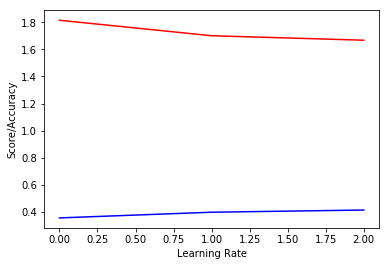

In [11]:
plt.plot(score_list, 'r', acc_list, 'b')
plt.xlabel('Learning Rate')
plt.ylabel('Score/Accuracy')
plt.show()

In [17]:
print("Learning Rate of 0.001: Score: " + str(score_list[0]) + " - Accuracy: " + str(acc_list[0]))
print("Learning Rate of 0.005: Score: " + str(score_list[1]) + " - Accuracy: " + str(acc_list[1]))
print("Learning Rate of 0.01: Score: " + str(score_list[2]) + " - Accuracy: " + str(acc_list[2]))

Learning Rate of 0.001: Score: 1.8159462215423583 - Accuracy: 0.3537
Learning Rate of 0.005: Score: 1.701442984008789 - Accuracy: 0.3959
Learning Rate of 0.01: Score: 1.6682677238464356 - Accuracy: 0.412


Learning rate of 0.001 is too small. The model have not converge yet by the 40th epoch. Learning rate of 0.005 and 0.01 appears to be able converge and triggered the early stop. However the use of adam optimiser was even better, it allowed for a faster convergent. 